# Summary:
**NOTE:** This notebook is supposed to be run on local machine.

In this notebook, an Exploratory Data Analysis for the **OPENSLR12** Audio dataset is done. This notebook will go through a variety of comparisons and distributions; landing the chance to understand the data more prior to creating the ML/DL model.
The dataset has gone through the pre-processing notebook and has been used to extract features that would assist in identifying the gender of the speaker.
Mentioning the availability of python's libraries has been true distinguishing and efficient in identifying some of the **key features** that would help us understand where our data is landing and how well the model will go-through the process of learning.

The extracted features are: 
- MFCCs
- Chroma (intensity)
- mel-scaled spectrogram
- Spectral Contrast
- Tonnetz
- Audio Duration
- Rate of speech
- \# of syllables
- Speaking time (s)
- Articulation (Speed) [Reference (Publication)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2790192/)
- Count of pauses with fillers
- Mean frequency
- Minimum frequency
- Maximum frequency

Regarding the frequency; males have a fundamental frequency of *85Hz* to *180Hz*, while females have are *168Hz* to *255Hz*. **_That is excluding vocals_.** [Reference (Wiki)](https://en.wikipedia.org/wiki/Voice_frequency#:~:text=The%20voiced%20speech%20of%20a,frequency%20band%20as%20defined%20above.)

**NOTE:** _Some of the features will be used in the model, some won't; that gets determined upon the relevance of the feature, e.g: Audio Duration, \# of syllables should not exist in the model becuase their existence will not be a true distinguisher between a 'male' and a 'female'_.

There are some steps that this notebook will pursue:
- Plot a signal for males and female selected audio-file with their MFCCs.
- Check out noisy/non-understandable data from the **Feature extraction** process and clean them out.
- Check if the dataset of both training and test sets are not skewed (balanced) in terms of Gender.
- Graph relationships given the features.
- Conclusion


In [4]:
import os
import librosa
import librosa.display
import random
import warnings
import re
from datetime import datetime
import time
import missingno

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')
#sns.set_palette("pastel")
#plt.style.use('seaborn')

**IMPORTANT:**
Specify the paths

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    print('Running on Colab, please run feature extraction on your local-machine if you do not want to run into issues, you can run the modeling on Google Colab.')
    
    train_csv = "/content/drive/My Drive/Google Colab/Data/NN_ML-data/train-clean-100.csv" 
    test_csv = "/content/drive/My Drive/Google Colab/Data/NN_ML-data/test-clean.csv"
    speech_examples = '/content/drive/My Drive/Google Colab/speech-examples/' 

else:
    print('Not Running on Google Colab')
    
    train_csv = "./Data/NN_ML-data/train-clean-100.csv" 
    test_csv = "./Data/NN_ML-data/test-clean.csv"
    speech_examples = "./speech-examples/"

Not Running on Google Colab


# Signal Visualization:

**Librosa Display function**


_Lets pick two audio files; one from a female and the other from a male. To Visualize those signals using Librosa's display function._

In [6]:
file_female = speech_examples + '103.flac'#The number 103 represents the speaker_id. (Female)
file_male = speech_examples + '911.flac' #The number 911 represents the speaker_id. (Male)

**Lets start with the female file.** 

_ladies first..._

_Time Domain:_

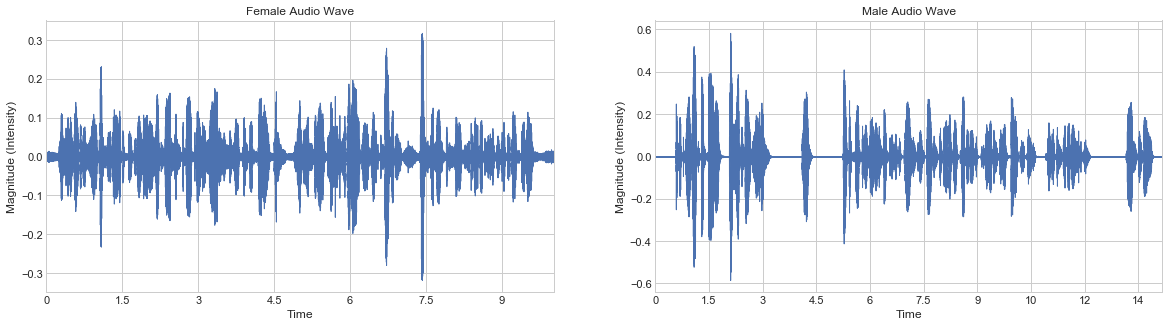

In [7]:
#Waveform
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
signal_female, sr_female = librosa.load(file_female, sr=22050)
librosa.display.waveplot(signal_female,sr=sr_female,ax=ax1)
ax1.set_title('Female Audio Wave')
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude (Intensity)')
#####
signal_male, sr_male= librosa.load(file_male, sr=22050)
librosa.display.waveplot(signal_male,sr=sr_male,ax=ax2)
ax2.set_title('Male Audio Wave')
ax2.set_xlabel('Time')
ax2.set_ylabel('Magnitude (Intensity)')
plt.show()

As per above, There is quite nothing to obtain from plotting the signal, but we can clearly observe the high-background noise that is occuring with all the oscillations due to many factors; could be the poor microphone quality, people talking in the background, car horn, etc.

**Possible solution:** Pass those signals through a low-pass filter to do noise reduction that would possible effect the way the Deep Learning model perceive the audio features (Will be left as a future work for this project).

_Frequency Domain:_

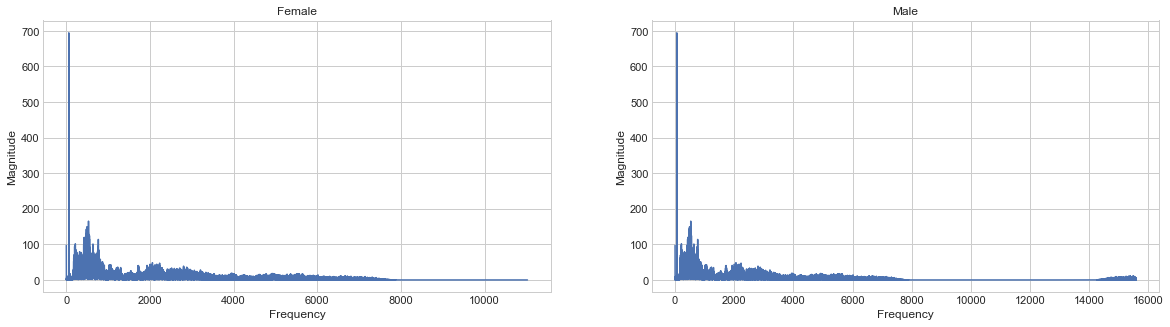

In [10]:
#fft --> Spectrum

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))

fft_female = np.fft.fft(signal_female) # Will output an array with the number of samples (22050 * Duration of Waveform)
mag_female = np.abs(fft_female)
freq_female = np.linspace(0, sr_female, len(mag_female)) #How much frequency is contributing to the whole sound.
#plt.plot(freq_female,mag_female) # This plot is semmetrical (Should take only the half part)
left_freq_female = freq_female[:int(len(freq_female)/2)]
left_mag_female = mag_female[:int(len(mag_female)/2)]
ax1.plot(left_freq_female,left_mag_female) 
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Magnitude')
ax1.set_title('Female')

#############################################

fft_male = np.fft.fft(signal_male) # Will output an array with the number of samples (22050 * Duration of Waveform)
mag_male = np.abs(fft_male)
freq_male = np.linspace(0, sr_male, len(mag_male)) #How much frequency is contributing to the whole sound.
#plt.plot(freq_male,mag_male) # This plot is semmetrical (Should take only the half part)
left_freq_male = freq_female[:int(len(freq_male)/2)]
left_mag_male = mag_female[:int(len(mag_male)/2)]
ax2.plot(left_freq_male,left_mag_male) 
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Magnitude')
ax2.set_title('Male');

As per above, most of the magnitude is centered toward the lower frequencies, this is a great graph to represent the signal in frequency domain.

_Time & Frequency Domain:_

**NOTE:** If you are on Google Colab, the below script will not work due to packages incompatibility, the issue is with the colorbars, comment them.

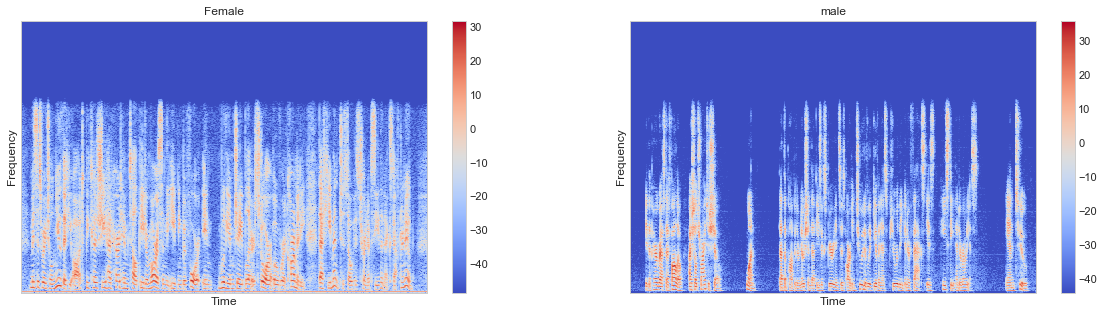

In [11]:
#Spectrogram (Time, freq with Intensity)
n_fft = 2048 #The number of samples when we perform one-fft

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))

stft = librosa.core.stft(signal_female,n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram =librosa.amplitude_to_db(spectrogram)
a = librosa.display.specshow(log_spectrogram, sr = sr_female,ax=ax1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.set_title('Female')

####################

stft = librosa.core.stft(signal_male,n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram =librosa.amplitude_to_db(spectrogram)
b = librosa.display.specshow(log_spectrogram, sr = sr_male,ax=ax2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
ax2.set_title('male')

fig.colorbar(a, ax=ax1)
fig.colorbar(b, ax=ax2);

As per above, you can clearly notice the difference in frequence of both genders from the graph. A lower frequence for most of the time is a male. You can notice in the Empty spaces when the male was speaking; the frequency is negligible.

_MFCCs_

**NOTE:** If you are on Google Colab, the below script will not work due to packages incompatibility, the issue is with the colorbars, comment them.

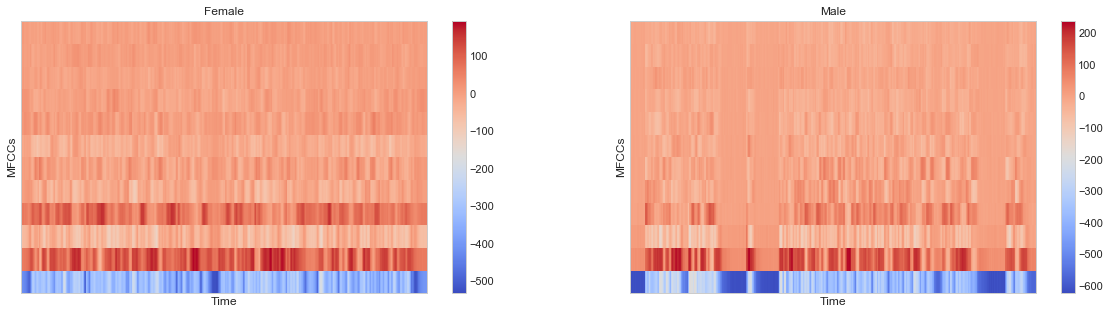

In [12]:
#MFCCs 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))

MFFCs_female = librosa.feature.mfcc(signal_female, n_fft = n_fft, n_mfcc=12) #12 so we can notice the coeffecients in the graph
a=librosa.display.specshow(MFFCs_female, sr=sr_female,ax=ax1)
ax1.set_xlabel('Time')
ax1.set_ylabel('MFCCs')
ax1.set_title('Female')

###################

MFFCs_male = librosa.feature.mfcc(signal_male, n_fft=n_fft, n_mfcc=12) #12 so we can notice the coeffecients in the graph
b=librosa.display.specshow(MFFCs_male, sr= sr_male,ax=ax2)
ax2.set_xlabel('Time')
ax2.set_ylabel('MFCCs')
ax2.set_title('Male')

fig.colorbar(a, ax=ax1)
fig.colorbar(b, ax=ax2);

These are the MFCCs coefficients that are being used as one of the first steps in Speech Recognition; which identifies the components of this signal and are quite distinguishing for seperating the linguistic content in the signal and discard all the other information like background noise, emotion, etc.. 
In this graph, the little squares are MFFCs coefficients with respect to time.
We can notice the difference in terms of both genders, they are definitely not identical which proves that indeed there is a difference. 
You can notice the same place where the Male speaker stopped speaking; the MFCC is 0, there is a strong correlation that MFCCs do indeed selectively choose the liguistic content.

# Audio Characteristics Analysis:

In this section, the features that were extracted from librosa are not analyzed; the features from parselmouth are the only ones who will be analyzed as the following:
- duration (seconds)
- rate_speech 
- syllables (# of syllables)
- pauses (# of pauses)
- speaking (seconds; excluding pauses)
- artic (Articulation; speed)
- freq_mean
- freq_min
- freq_max


In [6]:
dataset_train = pd.read_csv(train_csv) #This will be mostly used for visualizations.

dataset = dataset_train.drop(['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz'],axis=1)

In [9]:
dataset_test = pd.read_csv(test_csv)

In [10]:
dataset.head()

,id_speaker,duration,rate_speech,syllables,pauses,speaking,artic,freq_mean,freq_min,freq_max,gender
0,103,14.085,4.0,58.0,2.0,11.5,5.0,212.69,80.0,376.0,0
1,103,15.945,4.0,66.0,3.0,14.0,5.0,198.89,72.0,322.0,0
2,103,13.945,5.0,64.0,3.0,12.4,5.0,204.35,80.0,323.0,0
3,103,14.710,4.0,61.0,4.0,11.6,5.0,208.17,80.0,315.0,0
4,103,12.515,4.0,54.0,3.0,10.7,5.0,213.86,80.0,355.0,0


**Missing values:**

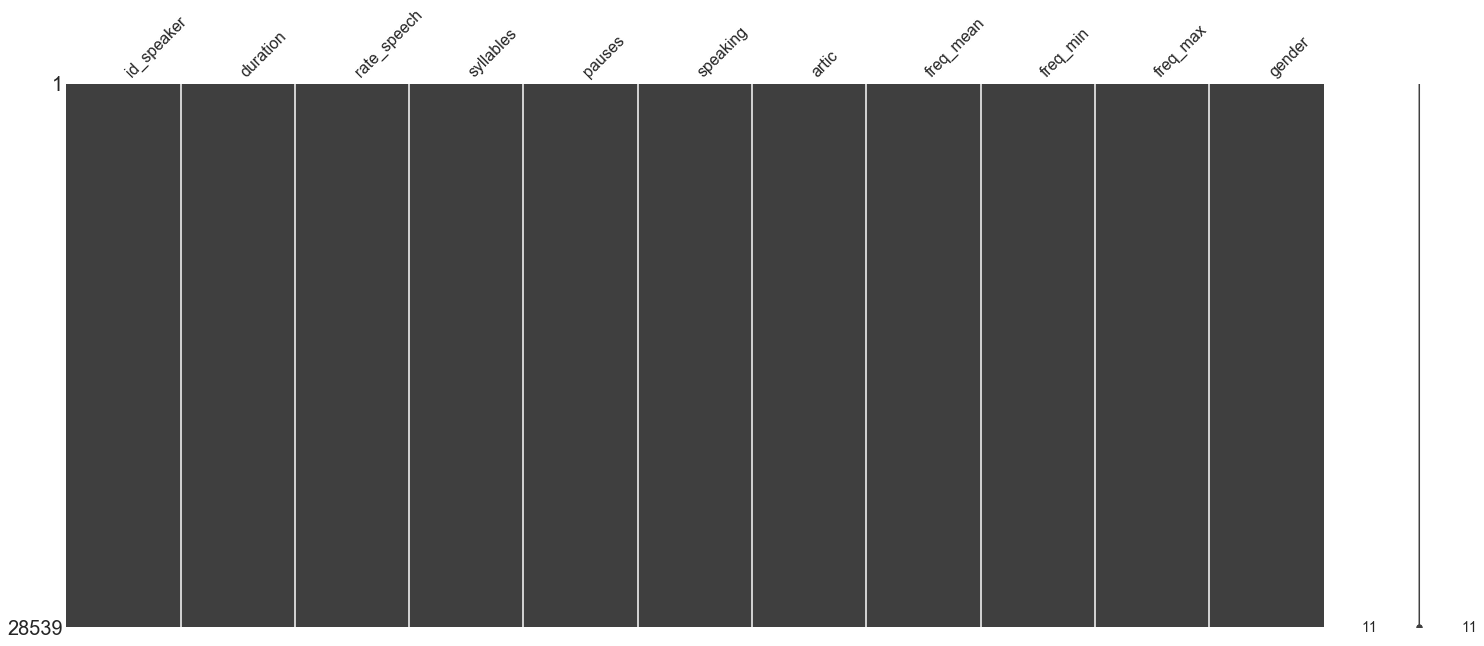

In [7]:
missingno.matrix(dataset)

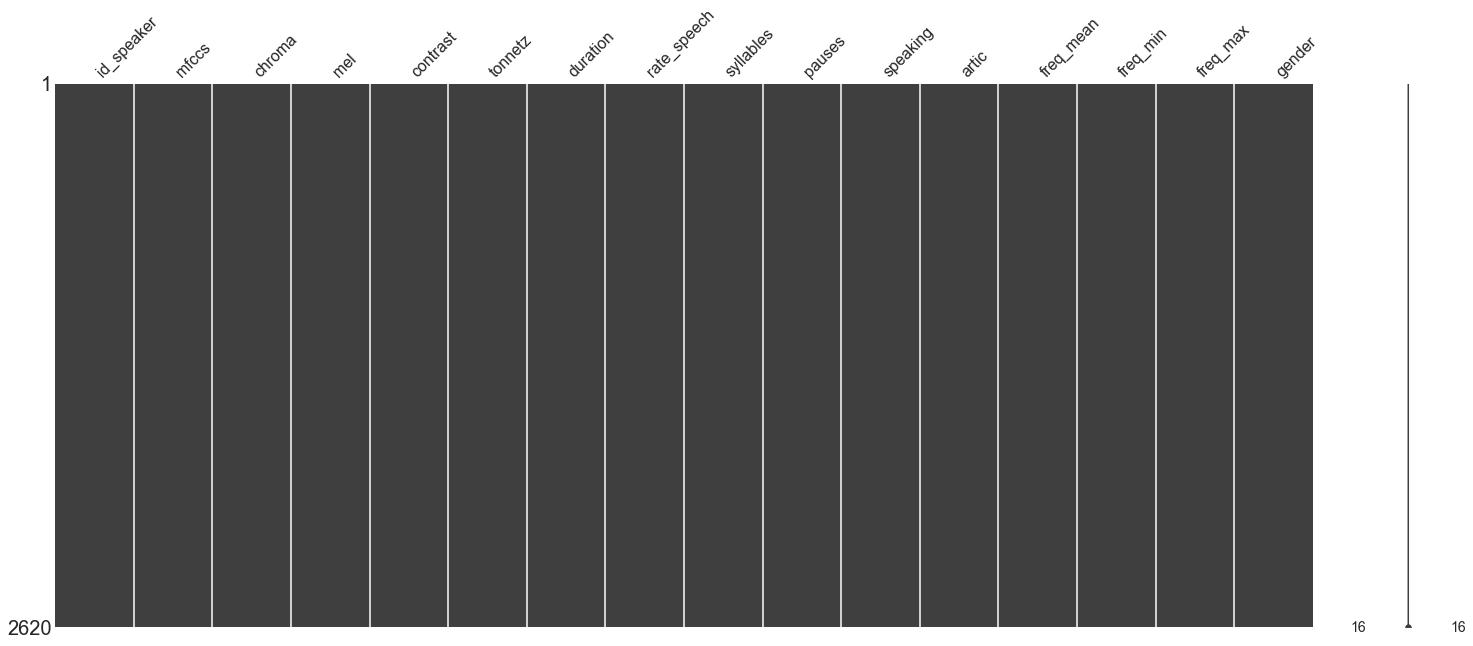

In [11]:
missingno.matrix(dataset_test)

_As per above, the data is clean with no missing values, but there are records that were not recognized by parselmouth._

In [9]:
dataset.loc[dataset['artic'] == -1]

,id_speaker,duration,rate_speech,syllables,pauses,speaking,artic,freq_mean,freq_min,freq_max,gender
114,1034,4.515,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
407,1081,3.795,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
480,1081,2.660,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
594,1088,4.375,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
674,1098,2.365,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
27257,8629,2.255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
28144,89,2.555,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
28195,89,3.740,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
28206,8975,6.415,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


_There are 543 Records with '-1' values are marked on purpose for being unrecognized by parselmouth library for being classified as 'unnatural sound' (High-background noise, microphone is cutting-off, words and sentences are not clear at all, etc.)_

**Let's clean off those values for our EDA. (Remove Noise):**

In [10]:
dataset.drop(dataset[dataset['artic']==-1].index, axis=0, inplace=True)

In [11]:
dataset.head()

,id_speaker,duration,rate_speech,syllables,pauses,speaking,artic,freq_mean,freq_min,freq_max,gender
0,103,14.085,4.0,58.0,2.0,11.5,5.0,212.69,80.0,376.0,0
1,103,15.945,4.0,66.0,3.0,14.0,5.0,198.89,72.0,322.0,0
2,103,13.945,5.0,64.0,3.0,12.4,5.0,204.35,80.0,323.0,0
3,103,14.710,4.0,61.0,4.0,11.6,5.0,208.17,80.0,315.0,0
4,103,12.515,4.0,54.0,3.0,10.7,5.0,213.86,80.0,355.0,0


**Count the number of speakers:**

In [19]:
print("The number of speakers are:", len(dataset['id_speaker'].unique()),'English speakers.')

The number of speakers are: 251 English speakers.


**Data count of gender balance:**

In [20]:
def bar_gender(gender='Training', dataset=dataset_train):
    """
    Count plot for both genders to check if the dataset is balanced or not.
    ...

    Parameters
    ----------
    gender : str
        gender type. e.g.: 'Female' or 'Male'.
    dataset : pd.DataFrame
        Dataset.
        
    """
    plt.figure(figsize=(11,7))
    a = sns.countplot(x=dataset['gender'],data=dataset)
    plt.title(gender + '-set - Count of Male vs Count of Female (By single record).')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    labels = [item.get_text() for item in a.get_xticklabels()]
    labels[0] = 'Female'
    labels[1] = 'Male'
    a.set_xticklabels(labels)
    plt.show()

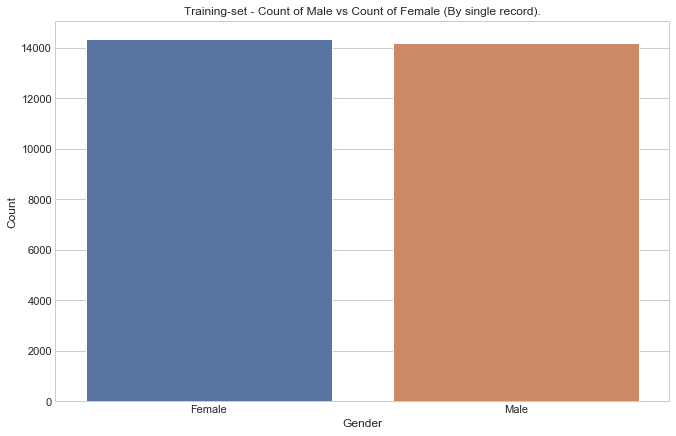

In [21]:
bar_gender()

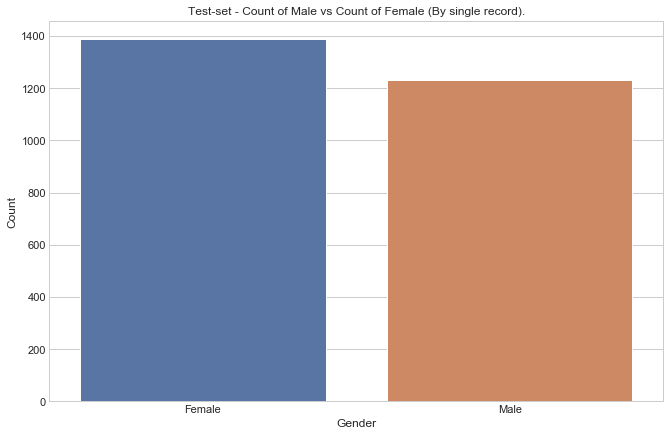

In [22]:
bar_gender('Test', dataset_test)

**Pair plot:**

_One of the most effective methods to get a general understanding of your data right before you start visualizing:_
- The first intuitive perception is that there is some sort of separation between both genders, which is clearly a good sign.
- There are some graphs that are unnecessary to be combined of.
- I think the mean-frequency will have the most impact in determining the gender of the speaker.
- I believe Articulation will have a good generalization. Reference: https://matinee.co.uk/blog/difference-male-female-voice/
- The effectiveness of Articulation can be tremendous according to many researchers, but it clearly depends on the age of the speaker, mood, and dialect; so as Articulation being one of the main features is debatable.

<Figure size 432x288 with 0 Axes>

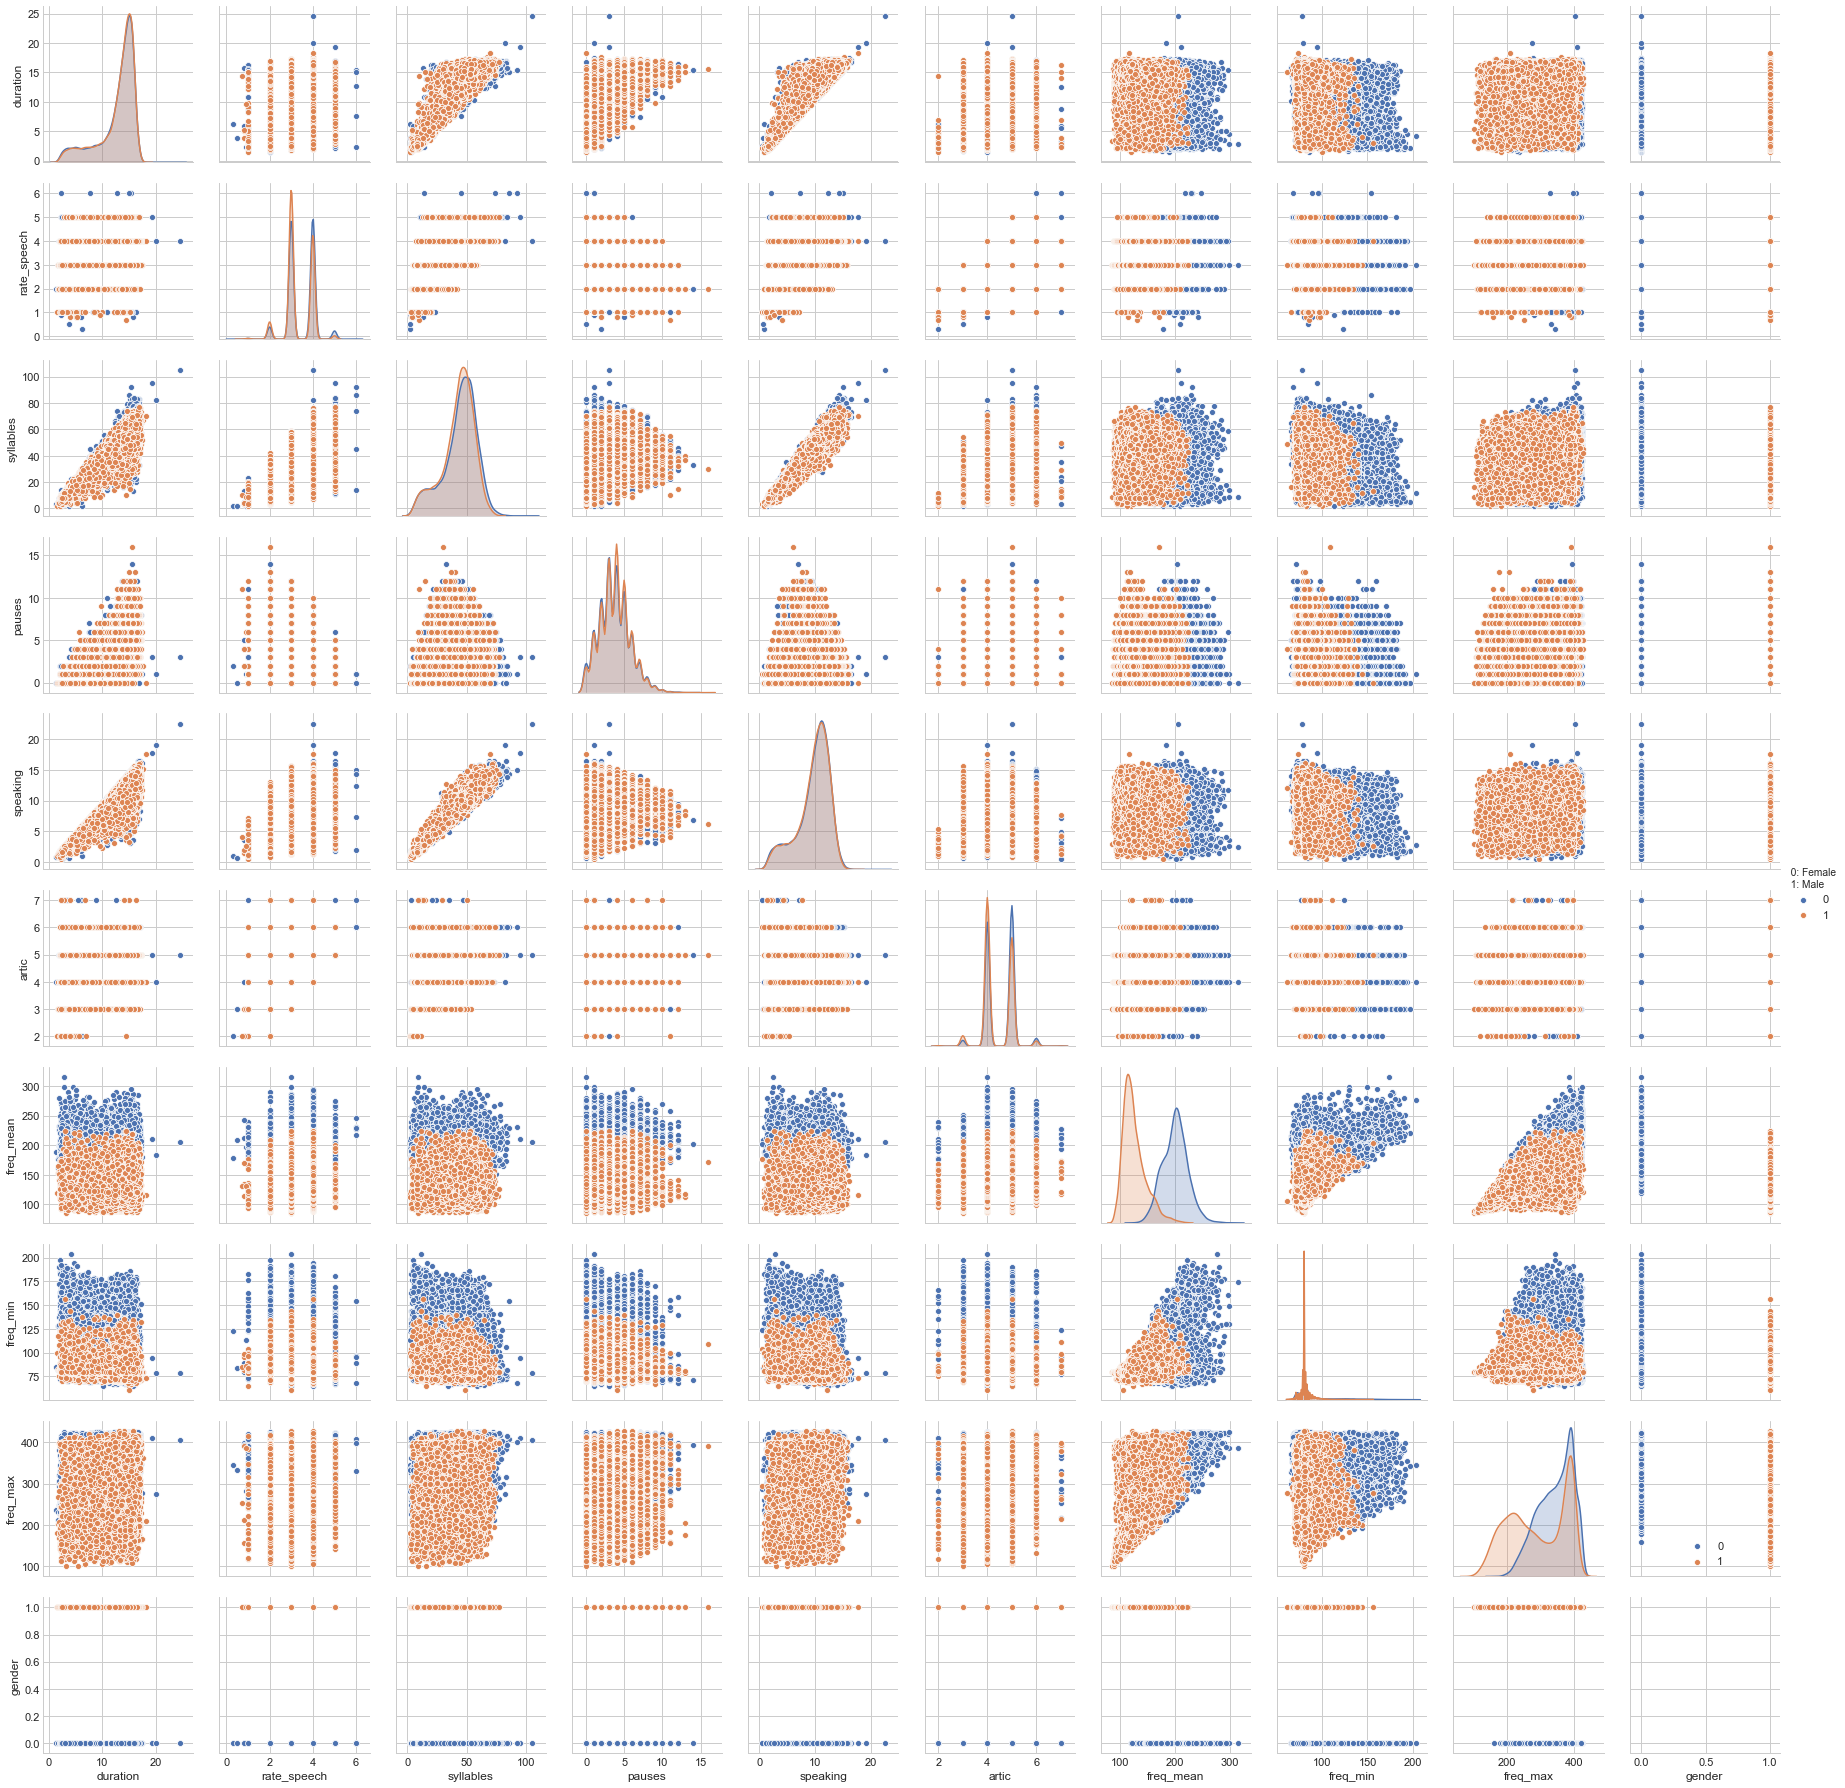

In [24]:
#To do every possible scatter with corresponding feature in the dataset.
plt.figure()
g = sns.pairplot(dataset.drop('id_speaker',axis=1), hue='gender')
g._legend.set_title('  0: Female\n  1: Male')
plt.legend()
plt.show()

**# of Syllables per gender:**

_**Definition:** a unit of pronunciation having one vowel sound, with or without surrounding consonants, forming the whole or a part of a word; for example, there are two syllables in water and three in inferno._

In [24]:
print('There are:',int(sum(dataset.loc[dataset['gender'] == 0,'syllables'])),'syllables for Female audio-files.')
print('There are:',int(sum(dataset.loc[dataset['gender'] == 1,'syllables'])),'syllables for Male audio-files.')

There are: 623374 syllables for Female audio-files.
There are: 599965 syllables for Male audio-files.


**Speaking time in seconds per gender:**

_Previously we've seen that the data was somewhat balanced; also it correlates with the fact that Females said more syllables than Males; but does it mean that the total duration of their respective gender is also balanced? What if Males spoke less syllables with more speaking time?_

_Let's check:_

In [25]:
print('There are',int(sum(dataset.loc[dataset['gender'] == 0,'speaking'])),'Seconds of continuous speaking for Females.')
print('There are',int(sum(dataset.loc[dataset['gender'] == 1,'speaking'])),'Seconds of continuous speaking for Males.')

There are 136810 Seconds of continuous speaking for Females.
There are 136096 Seconds of continuous speaking for Males.


_Now we can confirm that females spoke more than males in their audio files, so the correlation of Syllables and Speaking time in this case sits on well._

**Count of Pauses per gender:**

In [26]:
print('There are:',int(sum(dataset.loc[dataset['gender'] == 0,'pauses'])),'Pauses for Females.')
print('There are:',int(sum(dataset.loc[dataset['gender'] == 1,'pauses'])),'Pauses for Males.')

There are: 52156 Pauses for Females.
There are: 52947 Pauses for Males.


_As per above, since Females are having more speaking time and more syllables; now they have less pause-count, and that proves the validity of the assumption -> More speaking, less pauses. **Well This is quite unnecessary; as you can have a longer duration with more pauses than total syllables.**_

**Distribution plot for different column features:**

In [28]:
def plot_dist_gender(data, label_column, target_column, xlabel, figsize=(20, 5)):
    """
    Distribution plot for both genders based on a label column.
    ...

    Parameters
    ----------
    data : pd.DataFrame
        Dataset.
    label_column : str
        A label (column feature) to be selected from the dataset.
    target_column : str
        Target label.
    xlabel : str
        Label of x-axis to be shown on the graph.
    figsize : Tuple
        Tuple of height and width of the graph.
        
    """
    fig = plt.figure(figsize=figsize)
    sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Female"});
    sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Male"});
    plt.xlabel(xlabel)

_We can notice below that there is a good chunk of overlapping between both genders, Articulation might **NOT** be the best separator in this scenario._

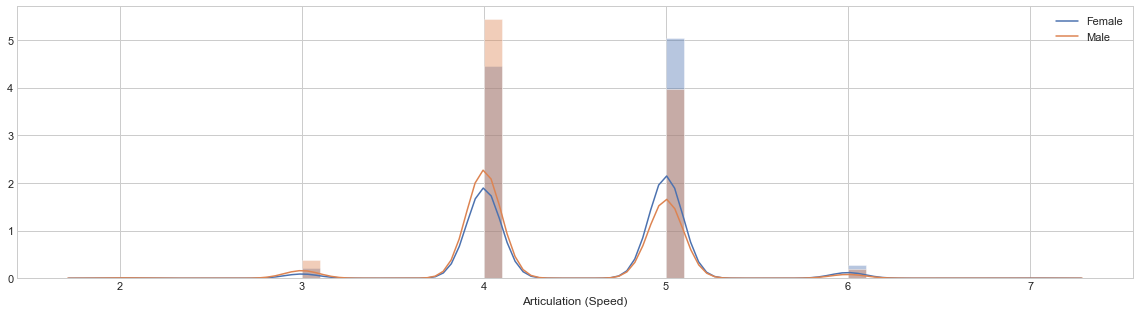

In [29]:
plot_dist_gender(dataset, 'gender', 'artic', xlabel = 'Articulation (Speed)')

_The mean-frequency truly distributs both genders!_

_The [Mean Fundamental Frequency](https://en.wikipedia.org/wiki/Voice_frequency#:~:text=The%20voiced%20speech%20of%20a,frequency%20band%20as%20defined%20above) for both genders is (in my opinion) the main key-feature to be focusing on._

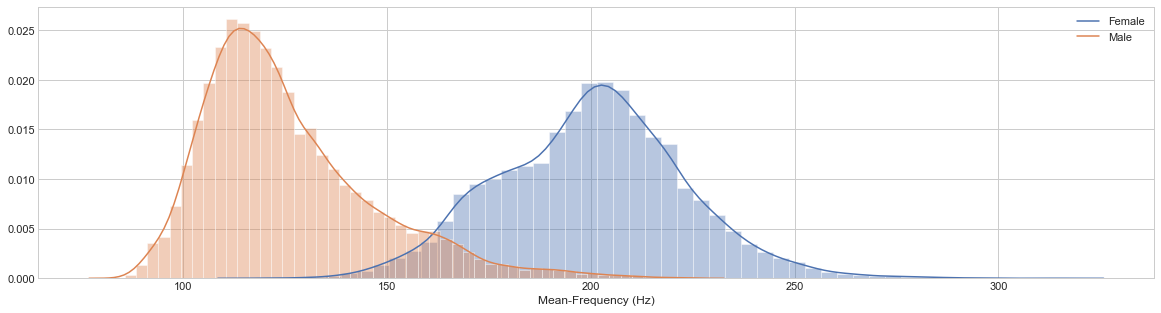

In [30]:
plot_dist_gender(dataset, 'gender', 'freq_mean', xlabel = 'Mean-Frequency (Hz)')

_The Maximum frequency does a moderate job at seperating, but the overlapping area is quite large as it opens rooms for fuzziness, that is due to the present noise in the audio files; but in general, it does a better job than Articulation, and its use as a main feature becomes true by trial-and-error._

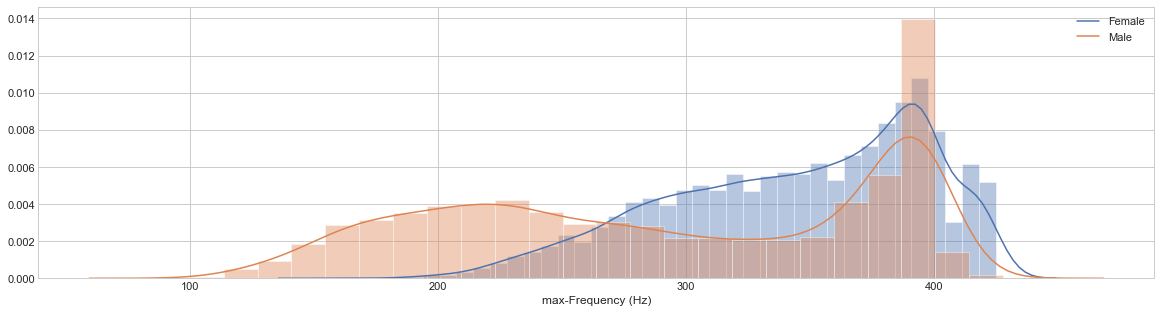

In [31]:
plot_dist_gender(dataset, 'gender', 'freq_max', xlabel = 'max-Frequency (Hz)')

_There are around 40-60 syllables for each audio file in average, which clearly demonstates that the audio files were not that long. Audio samples also present an almost identical distribution for both genders._

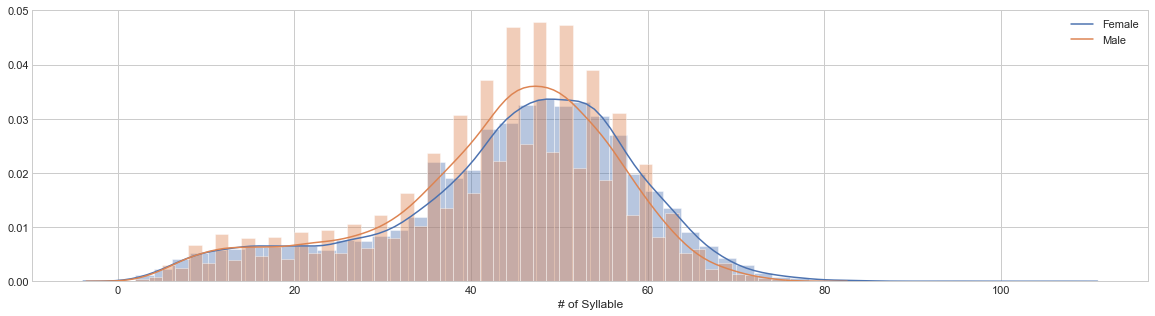

In [30]:
plot_dist_gender(dataset, 'gender', 'syllables', xlabel = '# of Syllable')

_Rate of speech is quite overlapping as well, but it generalizes more towards Males; where femals they tend to have an equal rate of speech for both values._

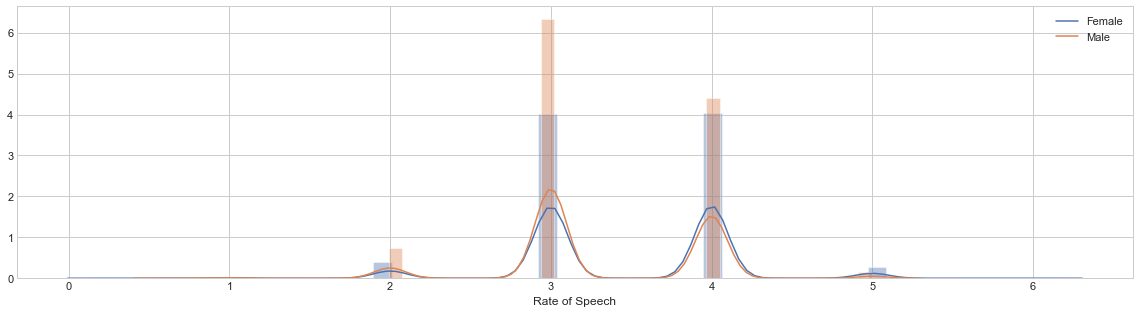

In [33]:
plot_dist_gender(dataset, 'gender', 'rate_speech', xlabel = 'Rate of Speech')

In [34]:
def dist_plot(data, label_column, fig_count=1):
    """
    General distribution plot based on a list of column features.
    ...

    Parameters
    ----------
    data : pd.DataFrame
        Dataset.
    label_column : list
        A list of  column features to be selected from the dataset.
    fig_count : int
        Number of graphs to be drawn.
        
    """
    fig, ax = plt.subplots(1,fig_count,figsize=(20,7))
    for i, ax in zip(range(fig_count), ax.flat):
        sns.distplot(dataset[label_column[i]],kde_kws={"label": label_column[i]}, ax=ax, color = random.choice(['red','blue','green','black','orange']))
    plt.tight_layout()
    plt.show()

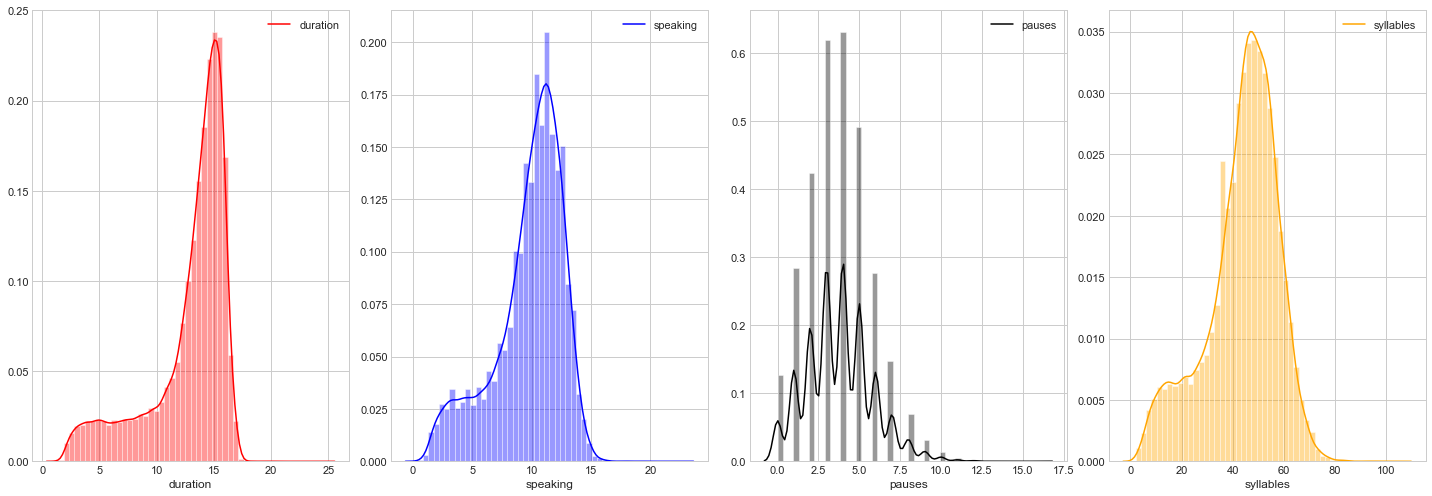

In [35]:
labels = ['duration', 'speaking', 'pauses', 'syllables']
dist_plot(dataset, labels, len(labels))

# Conclusion:
-  This EDA has demonstrated a general idea of what our data consists of.
-  Some features are truly essential in the process of creating the model like the mean and max frequency (Mean is more robust).
-  Features like Rate of Speech, articulation are 'almost' evenly distributed between both genders which might not be the best choice to choose those features.
-  There are features like Duration, speaking time, pauses, syllables are used to understand how our data is distributed, and shouldn't be used for this kind of classification problem.

**Furthur readings:**
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2790192/
- https://github.com/YannickJadoul/Parselmouth
- https://billdthompson.github.io/assets/output/Jadoul2018.pdf